### `ising2d` Library Reference

The **`ising2d`** module provides a high-performance C++/CUDA implementation of the 2D Ising Model, exposed to Python via Pybind11.

#### 1. Initialization
Create a new simulation object.
* **`model = ising2d.IsingModel(L, T, J=1.0, h=0.0, seed=42)`**
    * `L`: Lattice side length (e.g., 1024 produces a $1024 \times 1024$ grid).
    * `T`: Temperature (Theoretical Critical Temp $T_c \approx 2.269$).
    * `J`: Interaction strength (default 1.0).
    * `h`: External magnetic field (default 0.0).
    * `seed`: Seed for the random number generator.

#### 2. Simulation & Physics
Evolve the system using the specified backend.
* **`model.update(mode, steps)`**
    * `steps`: Integer number of Monte Carlo steps.
    * `mode`: The backend execution strategy:
        * `ising2d.Mode.SERIAL`: Single-core CPU (Slowest, baseline).
        * `ising2d.Mode.OPENMP`: Multi-core CPU.
        * `ising2d.Mode.CUDA_GLOBAL`: GPU using Global Memory.
        * `ising2d.Mode.CUDA_SHARED`: GPU using Shared Memory (Fastest).
* **`model.device_synchronize()`**
    * **Crucial for Benchmarking:** Blocks Python execution until the GPU has finished all queued tasks. Without this, your timing code will be incorrect because CUDA launches kernels asynchronously.

#### 3. Data Access & Memory Management
Access simulation data without copying memory buffers.
* **`model.lattice`**
    * Returns a **NumPy View** of the live spin grid.
    * **Read/Write:** Modifying this array in Python instantly updates the C++ memory.
    * **Format:** 2D array of integers (`-1` or `+1`).
* **`model.magnetization(mode)`**
    * Returns the average magnetization per spin $\langle m \rangle$.
* **`model.energy(mode)`**
    * Returns the total energy of the system $E$.
* **`model.copy_to_host()`**
    * Copies the lattice from device to host.
* **`model.copy_to_device()`**
    * Copies the lattice from host to device.



#### 4. Performance Tuning
Adjust hardware parameters on the fly.
* **`model.set_cuda_block_size(size)`**
    * Sets the CUDA thread block dimension (Valid: 8, 16, 32).
* **`model.set_num_threads(n)`**
    * Sets the number of CPU threads used by the `OPENMP` mode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys

project_path = "/home/william/MCP_project/Ising2D_with_CUDA"
if project_path not in sys.path:
    sys.path.append(project_path)

import ising2d




# Physics verification

First of all we try to see if the MCMC algorithm leads to the final predicted result

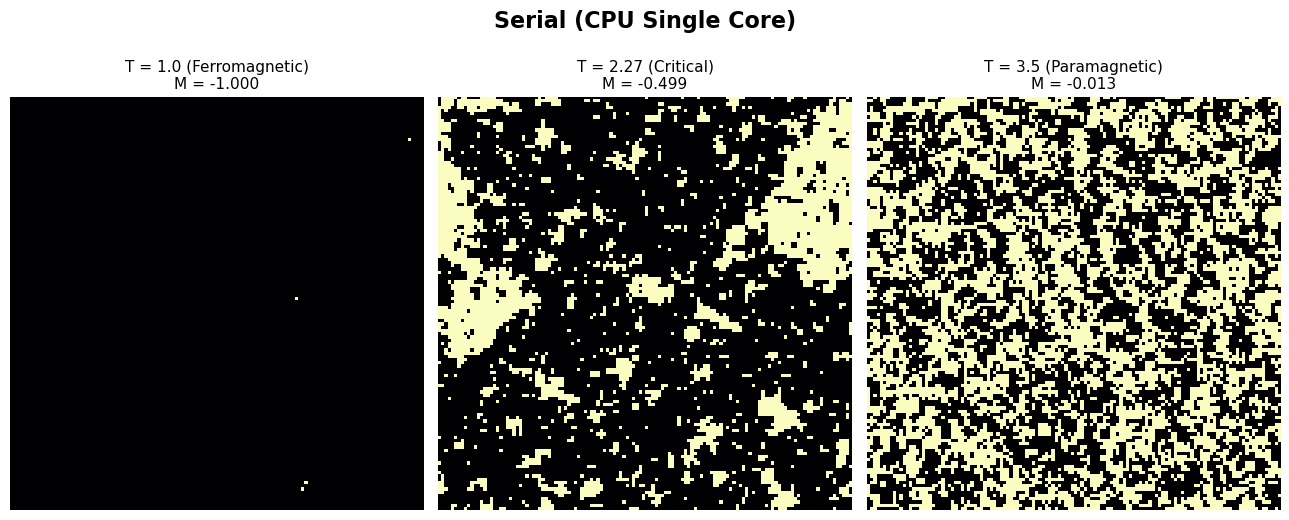

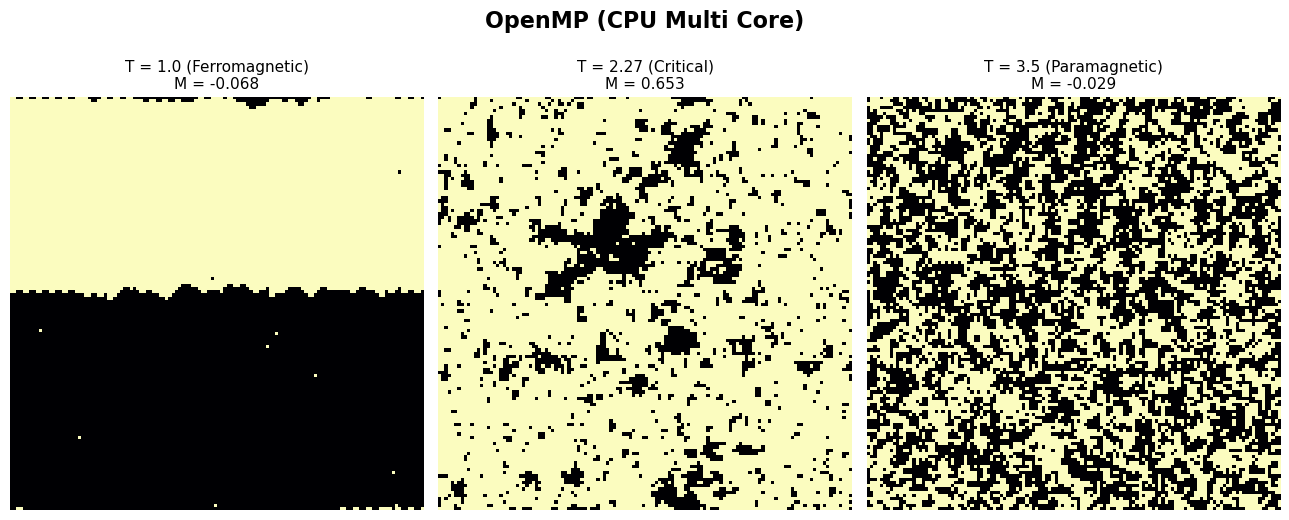

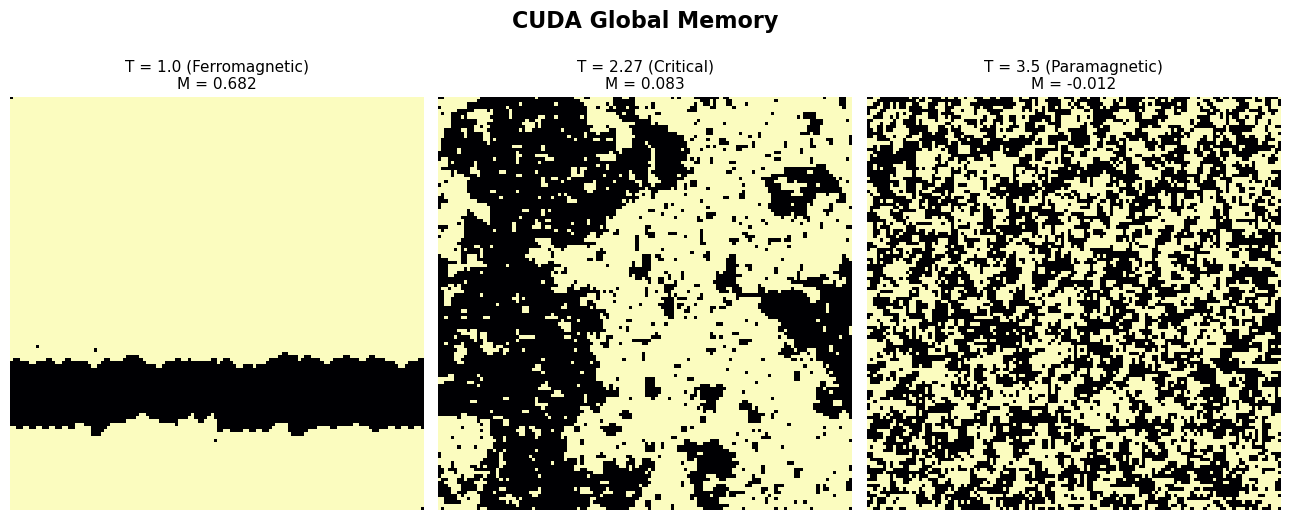

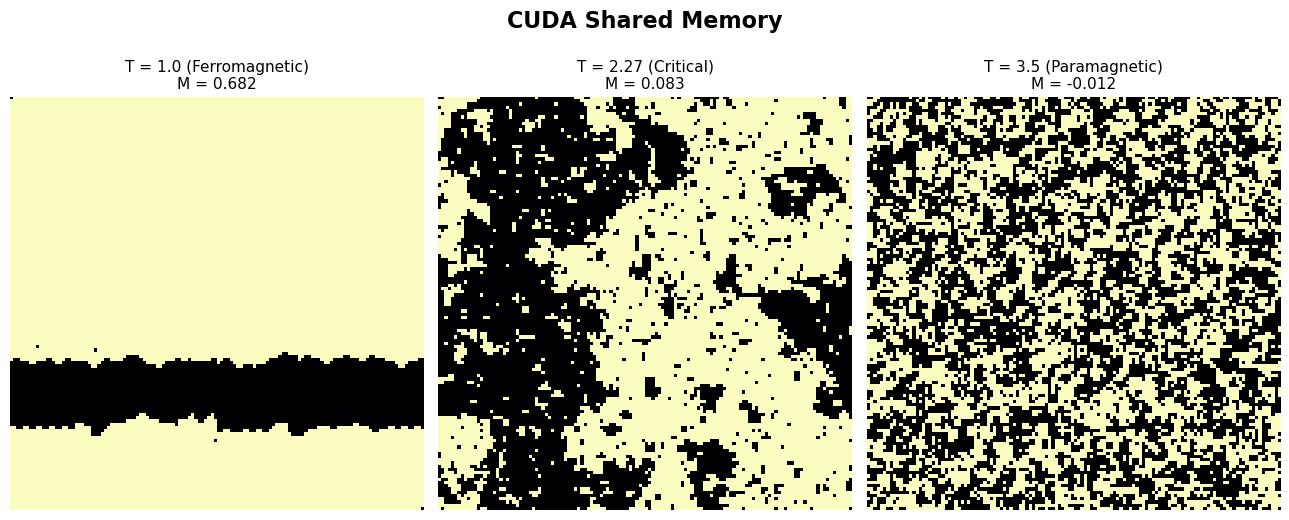

In [ ]:
# Simulation data
L = 128            
STEPS = 5000        
BLOCK_SIZE = 16      

modes = [
    (ising2d.Mode.SERIAL, "Serial (CPU Single Core)"),
    (ising2d.Mode.OPENMP, "OpenMP (CPU Multi Core)"),
    (ising2d.Mode.CUDA_GLOBAL, "CUDA Global Memory"),
    (ising2d.Mode.CUDA_SHARED, "CUDA Shared Memory")
]

#temperatures to scan
temps = [1.0, 2.27, 3.5]

for mode_enum, mode_title in modes:
    fig,ax = plt.subplots(1,3,figsize=(13,5))
    fig.suptitle(f"{mode_title}", fontsize=16, fontweight='bold', y=1.05)
    for j,T in enumerate(temps):
        
        model = ising2d.IsingModel(L,T,seed = 14)
        model.update(mode_enum,STEPS)
        
        if "CUDA" in mode_title:
            model.device_synchronize()
            model.copy_to_host()

        ax[j].imshow(model.lattice, cmap='magma', vmin=-1, vmax=1)
        
        # Calculate statistics for the subtitle
        m = np.mean(model.lattice)
        
        # titles
        phase_name = "Ferromagnetic" if T < 2.0 else "Critical" if T < 3.0 else "Paramagnetic"
        ax[j].set_title(f"T = {T} ({phase_name})\nM = {m:.3f}", fontsize=11)
        ax[j].axis('off')
        
    plt.tight_layout()
    plt.show()